# Evaluation of linear probing/finetuning models on EMBED dataset

In [2]:
import sys
import seaborn as sns

sys.path.append("/vol/biomedic3/mb121/causal-contrastive")

from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from classification.classification_module import ClassificationModule
from hydra import compose, initialize

from data_handling.mammo import EmbedDataModule, modelname_map
from evaluation.helper_functions import run_inference
rev_model_map = {v: k for k, v in modelname_map.items()}
import os

os.chdir("/vol/biomedic3/mb121/causal-contrastive/evaluation")

In [19]:
# Mapping from human readable run name to Weights&Biases run_id. 

# Human readable name should be in format:
# for finetuning:
# {simclr/simclrcf/simclrcfaug}-{train_prop}-{seed}
# for linear probing
# {simclr/simclrcf/simclrcfaug}head-{train_prop}-{seed}

model_dict = {
    "supervised-0.01-11": "pxt8qa9a",
    "supervised-0.01-22": "pejcf0g2",
    "supervised-0.01-33": "hanrntpx",
    "supervised-0.05-11": "tovoj1oa",
    "supervised-0.05-22": "36xkkga3",
    "supervised-0.05-33": "h5fg9j3v",
    "supervised-0.1-22": "cnmbk18a",
    "supervised-0.1-11": "zyni8hft",
    "supervised-0.1-33": "bhvd9v9r",
    "supervised-0.25-11": "qdbyxgq6",
    "supervised-0.25-22": "kzazkpjz",
    "supervised-0.25-33": "gh6adhz5",
    "supervised-1.0-33": "u1zedefy",
    "supervised-1.0-11": "ynv4elgn",
    "supervised-1.0-22": "qdjpdsbu",
    "simclrcf-0.01-11": "um1y3iln",
    "simclrcf-0.05-22": "stoqfdld",
    "simclr-0.05-22": "pf0uqv2e",
    "simclrcf-0.1-22": "jk0xk1yq",
    "simclr-0.05-11": "j7qg2zcf",
    "simclrcf-0.05-11": "ju9xfu6z",
    "simclr-0.1-22": "mh4exarz",
    "simclr-0.1-11": "3a1wft8u",
    "simclrcf-0.25-22": "w1muwi2v",
    "simclrcf-0.1-11": "2c8x9gr9",
    "simclr-0.25-22": "io9ukhfm",
    "simclrcf-0.05-33": "kkcbrb3i",
    "simclr-0.25-11": "tkr8tw5e",
    "simclrcf-0.25-11": "e8w1vxmn",
    "simclrcf-0.1-33": "bzyqmycb",
    "simclrcfaug-0.05-22": "z7pgwz4e",
    "simclrcfaug-0.05-11": "o98equwh",
    "simclrcfaug-0.05-33": "idly5nkx",
    "simclrcfaug-0.1-22": "ed1lg5j2",
    "simclrcfaug-0.1-11": "huouaf2h",
    "simclrcfaug-0.1-33": "glifyzd8",
    "simclrcfaug-0.25-22": "boijfg9v",
    "simclrcf-1.0-22": "0cf2wpg6",
    "simclr-1.0-22": "qz7qx7u3",
    "simclrcfaug-0.25-11": "gw92xdg1",
    "simclrcf-1.0-11": "012vx3f7",
    "simclr-1.0-11": "md4ymp1g",
    "simclrcfaug-0.25-33": "9tmsbgp8",
    "simclrcf-0.25-33": "3k1lu1oy",
    "simclrcfaug-1.0-22": "7lxph9ps",
    "simclrcfaug-1.0-33": "u4onu6om",
    "simclr-0.01-33": "hsyrkrpi",
    "simclr-0.01-22": "nsr3ixey",
    "simclr-0.01-11": "cpqdq4gs",
    "simclrcf-0.01-22": "qxvdehkn",
    "simclrcf-0.01-33": "nrz507vz",
    "simclrcfaug-0.01-11": "7heqiv3l",
    "simclrcfaug-0.01-22": "iw4v9i4d",
    "simclrcfaug-0.01-33": "hcabqnze",
    "simclrcf-1.0-33": "lhaovv2s",
    "simclr-0.05-33": "eissogv0",
    "simclr-0.1-33": "1wwpkejb",
    "simclr-0.25-33": "gx6u8o0b",
    "simclr-1.0-33": "d1zvpt88",
    "simclrcfaug-1.0-11": "b09dget0",

    'simclrcfaughead-0.01-33': 'uyi8igaj',
    'simclrcfhead-0.01-33': 'z2zjgali',
    'simclrhead-0.05-33': 'o81utb35',
    'simclrcfaughead-0.05-33': 'r139ejmw',
    'simclrcfhead-0.05-33': 'fz8292xk',
    'simclrhead-0.1-33': '91al13pn',
    'simclrcfaughead-0.1-33': 'z7grevzt',
    'simclrcfhead-0.1-33': 'hhd6tlvt',
    'simclrcfaughead-0.25-33': 'fsegzlrr',
    'simclrhead-0.25-33': 'lmnz6cqa',
    'simclrcfhead-0.25-33': 'dlny28wi',
    'simclrcfaughead-1.0-33': 'e3x6x3tm',
    'simclrhead-0.01-33': 'ydmewf9b',
    'simclrhead-1.0-33': 'pbgsgaxc',
    'simclrcfaughead-0.01-22': 'etd0yjt5',
    'simclrcfaughead-0.05-22': 'nap1oirc',
    'simclrcfaughead-0.1-22': 'l0i0oec0',
    'simclrcfhead-0.01-22': 'as4948zr',
    'simclrhead-0.05-22': '51zpigal',
    'simclrcfhead-0.05-22': 'zuc0cjjx',
    'simclrcfaughead-0.25-22': '1g7wiscd',
    'simclrhead-0.1-22': 'mt2wkl00',
    'simclrcfhead-0.1-22': 'giznbw9f',
    'simclrcfaughead-1.0-22': 'tgoc2e4j',
    'simclrhead-0.25-22': '3rxog9d2',
    'simclrcfhead-0.25-22': '7qvf5uo5',
    'simclrhead-0.01-22': 'rxk3y37s',
    'simclrcfhead-1.0-22': 'dwb7zktd',
    'simclrhead-1.0-22': 'e62b8afn',
    'simclrcfaughead-0.01-11': 'hpdjukli',
    'simclrcfaughead-0.05-11': '9o3czlda',
    'simclrcfaughead-0.1-11': 'pbi3veta',
    'simclrcfhead-0.01-11': '7w8ruf57',
    'simclrcfaughead-0.25-11': '1hk8svy4',
    'simclrhead-0.05-11': 'f4dvy97m',
    'simclrcfhead-0.05-11': '2pe5jd0v',
    'simclrhead-0.1-11': 'hax3h4uo',
    'simclrcfhead-0.1-11': 'udbj16e9',
    'simclrhead-0.25-11': 'vb1al6q2',
    'simclrcfhead-0.25-11': 'eclgsmot',
    'simclrcfaughead-1.0-11': 'e5pcbl23',
    'simclrhead-0.01-11': 'xqja0tjy',
    'simclrcfhead-1.0-11': 'j6jbom7s',
    'simclrhead-1.0-11': 'ui1zuhsu',
}

In [ ]:
with initialize(version_base=None, config_path="../configs"):
    cfg = compose(
        config_name="config.yaml",
        overrides=["experiment=base_density", "data.cache=False"],
    )
    print(cfg)
    data_module = EmbedDataModule(config=cfg)
test_loader = data_module.test_dataloader()

In [20]:
df = pd.read_csv(f"../outputs/classification_{cfg.data.label}_results_finetune2.csv")
for run_name, run_id in model_dict.items():
    already_in_df = run_name in df.run_name.values
    if run_id != "" and not already_in_df:
        print(run_name)
        model_to_evaluate = f"../outputs/run_{run_id}/best.ckpt"
        classification_model = ClassificationModule.load_from_checkpoint(
            model_to_evaluate, map_location="cuda"
        ).model.eval()
        classification_model.cuda()

        # ID evaluation
        inference_results = run_inference(test_loader, classification_model)
        scanners = np.argmax(inference_results["scanners"], 1)

        for i in np.unique(scanners):
            print(f"\nEvaluating scanner {i}")
            sc_idx = np.where(scanners == i)
            targets = inference_results["targets"][sc_idx]
            preds = np.argmax(inference_results["confs"], 1)[sc_idx]
            confs = inference_results["confs"][sc_idx]
            res = {}
            res["N_test"] = [targets.shape[0]]
            res["ROC"] = [roc_auc_score(targets, confs, multi_class="ovr")]
            res["Model Name"] = [rev_model_map[i]]
            res["run_name"] = run_name
            print(res)
            df = pd.concat([df, pd.DataFrame(res, index=[0])], ignore_index=True)

        df.to_csv(
            f"../outputs/classification_{cfg.data.label}_results_finetune2.csv",
            index=False,
        )

## Plotting embeddings

In [4]:
model_dict_for_embeddings = {
    "SimCLR": "byatk1eo",
    "SimCLR with CF in training set": "jv9hzx89",
    "CF-SimCLR": "kywspwfs",
}

In [ ]:
from evaluation.helper_functions import run_get_embeddings
from sklearn.manifold import TSNE

results = {}

for run_name, run_id in model_dict_for_embeddings.items():
    if run_id != "":
        print(run_name)
        model_to_evaluate = f"../outputs/run_{run_id}/epoch=449.ckpt"
        classification_model = ClassificationModule.load_from_checkpoint(
            model_to_evaluate, map_location="cuda"
        ).model.eval()
        classification_model.cuda()
        # ID evaluation
        inference_results = run_get_embeddings(
            test_loader, classification_model, max_batch=500
        )
        inference_results["scanners"] = np.argmax(inference_results["scanners"], 1)
        results[run_name] = inference_results

/tmp/ipykernel_3921778/1227141076.py:9: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_3921778/1227141076.py:9: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_3921778/1227141076.py:9: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(


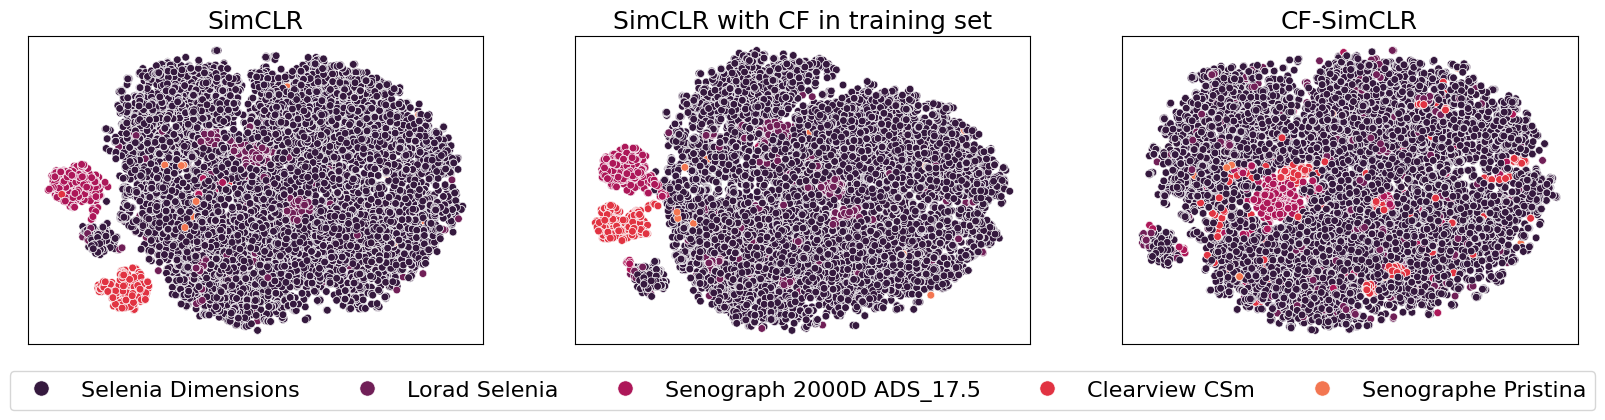

In [6]:

f, ax = plt.subplots(1, len(results.keys()), figsize=(20, 4))
for i, (run_name, inference_results) in enumerate(results.items()):
    scanners = inference_results["scanners"]
    idx = np.where(scanners != -1)[0]
    targets = inference_results["targets"]
    tsne = TSNE(n_jobs=6, perplexity=30)
    x2d = tsne.fit_transform(inference_results["feats"][idx])
    scanners_plot = [rev_model_map[s] for s in scanners[idx]]
    sns.scatterplot(
        x=x2d[idx, 0],
        y=x2d[idx, 1],
        hue=scanners_plot,
        ax=ax[i],
        palette=sns.color_palette("rocket"),
        legend=i == 1,
        alpha=1.0,
        s=30,
    )
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(run_name, fontsize=18)
ax[1].legend(
    loc="center", bbox_to_anchor=(0.5, -0.15), ncol=6, fontsize=16, markerscale=2
)
plt.savefig("embeddings_tsne.png", bbox_inches="tight", dpi=500)